In [1]:
from catinous.RetinaNetDetection import *
from catinous.LUNADataset import LUNADataset
import matplotlib.pyplot as plt
import os
import sys
py_dll_path = os.path.join(sys.exec_prefix, 'Library', 'bin')
os.environ['PATH'] += py_dll_path
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import collections
import torchvision
import nms
import matplotlib.patches as patches
import pydicom as pyd
import pandas as pd
%load_ext autoreload
%autoreload 


Bad key "text.kerning_factor" on line 4 in
/home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
device = torch.device('cuda')
ds = LUNADataset('/project/catinous/lunadata/luna_lunacombined_dataset.csv', split=['base_train'], labelDebug=1)
dl = DataLoader(ds, batch_size=8, num_workers=4, shuffle=True)
model = resnet50(num_classes=2, pretrained=True).to(device)
#model = torch.nn.DataParallel(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-5)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1, verbose=False)

model.train()
#model.freeze_bn()
print('s')

s


In [3]:
for epoch_num in range(100):
    model.train()
    model.freeze_bn()

    epoch_loss = []
    running_loss = 0.0
    running_class = 0.0
    running_regress = 0.0
    
    for iter_num, data in enumerate(dl):
        optimizer.zero_grad()

        img = torch.FloatTensor(data[0].float()).to(device)
        classification_loss, regression_loss = model([img, data[1].float().to(device)])

        classification_loss = classification_loss.mean()
        regression_loss = regression_loss.mean()

        loss = classification_loss + regression_loss
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)

        optimizer.step()
        
        running_loss += loss.item()
        running_class += classification_loss.item()
        running_regress += regression_loss.item()
        
    print(
        'Epoch: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
            epoch_num, float(running_class/len(dl)), float(running_regress/len(dl)), float(running_loss/len(dl))))
    
    scheduler.step()

Epoch: 0 | Classification loss: 0.72070 | Regression loss: 0.47134 | Running loss: 1.19204
Epoch: 1 | Classification loss: 0.55681 | Regression loss: 0.41724 | Running loss: 0.97405
Epoch: 2 | Classification loss: 0.47716 | Regression loss: 0.39010 | Running loss: 0.86726
Epoch: 3 | Classification loss: 0.40414 | Regression loss: 0.38621 | Running loss: 0.79035
Epoch: 4 | Classification loss: 0.34699 | Regression loss: 0.34162 | Running loss: 0.68861
Epoch: 5 | Classification loss: 0.37103 | Regression loss: 0.32189 | Running loss: 0.69292
Epoch: 6 | Classification loss: 0.32540 | Regression loss: 0.30509 | Running loss: 0.63050
Epoch: 7 | Classification loss: 0.27697 | Regression loss: 0.27540 | Running loss: 0.55238
Epoch: 8 | Classification loss: 0.35037 | Regression loss: 0.26865 | Running loss: 0.61902
Epoch: 9 | Classification loss: 0.28662 | Regression loss: 0.24471 | Running loss: 0.53133
Epoch: 10 | Classification loss: 0.21332 | Regression loss: 0.21235 | Running loss: 0.4256

In [4]:
torch.save(model.state_dict(), 'basetrain_debug.pt')

In [2]:
device = torch.device('cuda')
ds = LUNADataset('/project/catinous/lunadata/luna_lunacombined_dataset.csv', split=['base_train'])
dl = DataLoader(ds, batch_size=4, num_workers=4, shuffle=True)
model = resnet50(num_classes=2, pretrained=True).to(device)
#model = torch.nn.DataParallel(model).to(device)
model.load_state_dict(torch.load('basetrain_debug.pt'))

<All keys matched successfully>

In [4]:
ds_val = LUNADataset('/project/catinous/lunadata/luna_lunacombined_dataset.csv', split=['val'], res='ges')
dl_val = DataLoader(ds_val, batch_size=1, num_workers=4, shuffle=False)

model.eval()
true_boxes = []
pred_boxes = []
imgs = []
res = []
scores = []
classes = []
for iter_num, data in enumerate(dl_val):
    img = torch.FloatTensor(data[0].float()).to(device)
    out = model(img)
    #print(out)
    #if len(out[0])>0:
    true_boxes.append(data[1].numpy()[0][0])
    pred_boxes.append(out[2].cpu().detach().numpy())
    scores.append(out[0].cpu().detach().numpy())
    res.append(data[3])
    imgs.append(data[2])
    classes.append(out[3].cpu().detach().numpy())

1 tensor(131, device='cuda:0')
[85, 62, 106, 68, 79, 41, 45, 91, 19, 48, 118, 75, 13, 124, 52, 1, 35, 113, 72, 33, 112, 129]
1 tensor(6, device='cuda:0')
[1]
1 tensor(415, device='cuda:0')
[112, 95, 125, 84, 163, 233, 353, 215, 16, 280, 57, 311, 31, 328, 202, 412, 388, 197, 10, 407, 6, 35, 323]
1 tensor(485, device='cuda:0')
[395, 85, 337, 363, 162, 183, 275, 463, 415, 371, 438, 200, 482, 5, 261, 56, 52, 469, 484, 407]
1 tensor(99, device='cuda:0')
[39, 89, 19, 15, 31, 51, 6, 95, 75, 28]
1 tensor(12, device='cuda:0')
[2, 4, 6]
1 tensor(65, device='cuda:0')
[11, 17, 49, 44, 23, 54, 0, 5]
1 tensor(359, device='cuda:0')
[58, 173, 160, 50, 189, 154, 33, 280, 8, 274, 84, 327, 334, 212, 44, 269, 149, 354, 332, 303, 352, 358, 4, 208]
1 tensor(5, device='cuda:0')
[3]
1 tensor(20, device='cuda:0')
[9, 15, 3]
1 tensor(682, device='cuda:0')
[276, 288, 260, 134, 140, 175, 124, 446, 304, 429, 464, 335, 150, 42, 594, 63, 578, 34, 165, 49, 669, 609, 483, 567, 326, 55, 659, 319, 678, 618, 495, 656, 15

[0.15866034 0.15498711 0.14844596 0.14217784 0.14027315 0.13851902
 0.13831569 0.1380077  0.1327714  0.12392547 0.1229414  0.12117923
 0.11926202 0.11884782 0.11455445 0.10997722 0.10284651 0.10122596
 0.10054976 0.10019893]


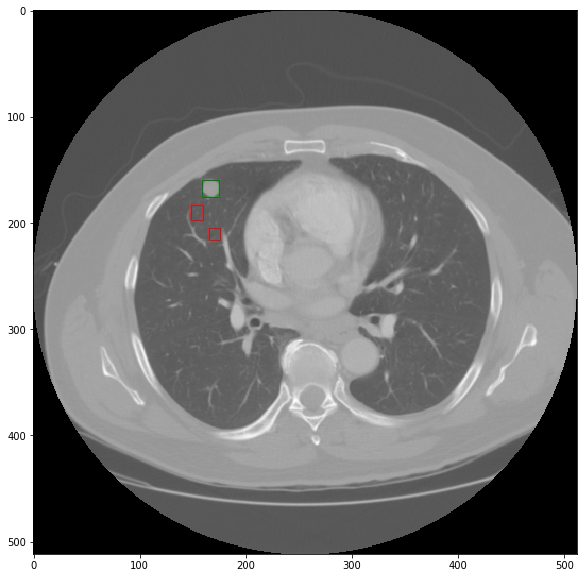

In [10]:
idx = 10
print(scores[idx])

xywh = [[ab[0], ab[1], ab[2] - ab[0], ab[3] - ab[1]] for ab in pred_boxes[idx]]
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
img = pyd.read_file(imgs[idx][0]).pixel_array
ax.imshow(img)
#plt.scatter([x], [y])
for k, xy in enumerate(xywh):
    if scores[idx][k]>0.15:
        rect = patches.Rectangle((xy[0],xy[1]),xy[2],xy[3],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
gt = true_boxes[idx]
rect = patches.Rectangle((gt[0], gt[1]), gt[2] - gt[0], gt[3] - gt[1], edgecolor='g', facecolor='none')
ax.add_patch(rect)

In [13]:
for k, box in enumerate(pred_boxes[idx]):
    if scores[idx][k]>0.15:
        print(bb_intersection_over_union(box, gt))

0.3564741005571157
0


In [6]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
    boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou